# Semifinal Я профессионал Mashine learing Perla L.A.

## Loading libs and defining utils-functions

In [1]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
import pickle
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def metrics_eval(y_true, y_pred, res=True):
    """
    Evaluate MAE, MSE, SMAPE, RMSE, MAPE metrics
    :param y_true: np.array of true values
    :param y_pred: np.array of predicted values
    :param res: bool, printing results
    :return: list of metrics
    """
    # Mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean squared error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y_true - y_pred) / ((y_true + y_pred) / 2))) * 100

    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    if res:
        print('Mean Absolute Error:', round(mae, 3))
        print('Mean Squared Error:', round(mse, 3))
        print('Root Mean Squared Error:', round(rmse, 3))
        print('Mean absolute percentage error:', round(MAPE, 3))
        print('Scaled Mean absolute percentage error:', round(SMAPE, 3))

    return mae, mse, rmse, MAPE, SMAPE

## Get data

In [6]:
train_df = pd.read_csv(os.path.join('data',"Training_wells.csv"))
pred_df = pd.read_csv(os.path.join('data', "Empty_part.csv"))

In [11]:
# from pandas_profiling import ProfileReport
# ProfileReport(train_df)

In [12]:
# ProfileReport(pred_df)

In [13]:
features_names = ["X", "Y"]
target_name = "NTG"

<AxesSubplot:xlabel='X', ylabel='Y'>

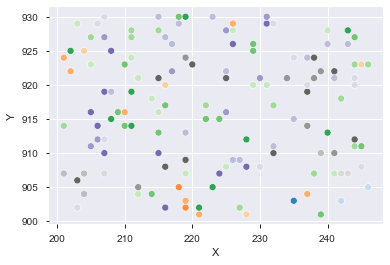

In [14]:
sns.scatterplot(data=train_df, x="X", y="Y", hue="NTG", palette="tab20c_r",legend=False)

## Data Process

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split

In [16]:
my_scaler = MinMaxScaler()
std_train_features = pd.DataFrame(my_scaler.fit_transform(train_df[features_names]),
                            columns=features_names)

X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(std_train_features,
                                                    train_df[target_name],
                                                    train_size=0.90, 
                                                    random_state=42)
print(y_train_std.size, y_test_std.size)

124 14


In [17]:
def prediction_plot(model, scaler=None, save_dir=None):
    
    # Pred
    pred_df_check = pred_df.copy()
    pred_df_check = pred_df_check.drop("Well", axis=1)

    if scaler is not None:
        to_model = my_scaler.transform(pred_df[features_names])
        X_train_inv = pd.DataFrame(my_scaler.inverse_transform(X_train_std), columns=features_names)
        y_train_inv = y_train_std.reset_index(drop=True)
        X_test_inv = pd.DataFrame(my_scaler.inverse_transform(X_test_std), columns=features_names)
        y_test_inv = y_test_std.reset_index(drop=True)
    else:
        to_model = pred_df[features_names]
        X_train_inv = X_train.copy()
        y_train_inv = y_train.copy()
        X_test_inv =  X_test.copy()
        y_test_inv = y_test.copy()
        
    to_model = pd.DataFrame(to_model, columns=features_names)
    pred_df_check[target_name] = np.array(model.predict(to_model)).reshape(-1)
    pred_df_check["Type"] = "Pred"

    # train
    train_df_check = pd.concat([X_train_inv, y_train_inv], axis=1)
    pred_df_check = pd.concat([pred_df_check, train_df_check], axis=0).fillna("Train")

    # test
    test_df_check = pd.concat([X_test_inv, y_test_inv], axis=1)
    pred_df_check = pd.concat([pred_df_check, test_df_check], axis=0).fillna("Test")
    
    sns.scatterplot(data=pred_df_check, x="X", y="Y", hue="NTG",
                    style="Type",
                    palette="tab20c_r")
    plt.legend(bbox_to_anchor=(1, 1), loc=2) 
    if save_dir is not None:
        plt.savefig(f'./{save_dir}/plot.jpg')
    plt.show()

In [18]:
def save_prediction(model, scaler=None):

    # take model name
    model_name = str(type(model)).strip("''<>").split('.')[-1]
    
    # Pred
    pred_df_check = pred_df.copy()

    if scaler is not None:
        to_model = my_scaler.transform(pred_df[features_names])
    else:
        to_model = pred_df[features_names]
        
    to_model = pd.DataFrame(to_model, columns=features_names)
    pred_df_check[target_name] = np.array(model.predict(to_model)).reshape(-1)
    
    
    # save predictions
    new_dir_name = f"./results/{model_name}_{datetime.now().strftime('%d.%m.%Y_%H:%M:%S')}"
    os.mkdir(new_dir_name)
    
    pred_df_check.to_csv(f"{new_dir_name}/{model_name}_{datetime.now().strftime('%d.%m.%Y_%H:%M:%S')}.csv",
                         header=True,
                         index=False)
    with open(f'{new_dir_name}/{model_name}.pickle', 'wb') as f:
        pickle.dump(model, f)
    
    prediction_plot(model, scaler, save_dir=new_dir_name)
    
    return pred_df_check

## Neural Net

In [16]:
import keras

my_callbacks = [keras.callbacks.EarlyStopping(patience=30),
                keras.callbacks.ModelCheckpoint(
                    filepath='best_model.h5',
                    monitor='val_loss',
                    save_weights_only=True,
                    mode='auto',
                    save_best_only=True)
]

nn_model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(X_train_std.shape[1],)),
    keras.layers.Dense(128,
                       activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512,
                       activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1024,
                       activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512,
                       activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128,
                       activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,
                       activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1),
])

nn_model.compile(optimizer='adam',
              loss="mse",
              metrics=["mse"],)

nn_model.fit(X_train_std,
             y_train_std,
             epochs=200,
             validation_data=(X_test_std, y_test_std),
             verbose=1,
             callbacks=my_callbacks,
             batch_size=20
            )

nn_model.load_weights("best_model.h5")

Using TensorFlow backend.


Train on 124 samples, validate on 14 samples
Epoch 1/200
124/124 [==============================] - 2s 12ms/step - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 2/200
124/124 [==============================] - 0s 2ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 3/200
124/124 [==============================] - 0s 2ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 4/200
124/124 [==============================] - 0s 2ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 5/200
124/124 [==============================] - 0s 2ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/200
124/124 [==============================] - 0s 2ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 7/200
124/124 [==============================] - 0s 2ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 8/200
124/124 [==

Mean Absolute Error: 0.035
Mean Squared Error: 0.002
Root Mean Squared Error: 0.043
Mean absolute percentage error: 10.865
Scaled Mean absolute percentage error: 10.96


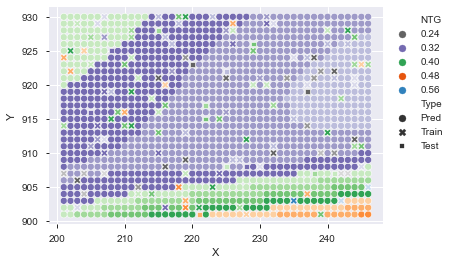

In [17]:
metrics_eval(y_test_std, nn_model.predict(X_test_std).flatten());
prediction_plot(model=nn_model,scaler=my_scaler)

## KNeighborsRegressor id = 48960598

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features_names],
                                                    train_df[target_name],
                                                    train_size=0.90, 
                                                    random_state=42)
print(y_train.size, y_test.size)

124 14


Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   44.9s finished


Mean Absolute Error: 0.043
Mean Squared Error: 0.003
Root Mean Squared Error: 0.055
Mean absolute percentage error: 12.663
Scaled Mean absolute percentage error: 13.972


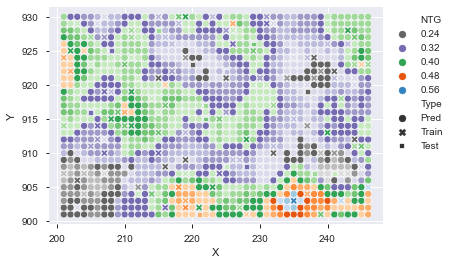

In [19]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

knr_model = KNeighborsRegressor(n_jobs=-1)

params = {
    "n_neighbors": [2,4,5,6,8],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": [3,5,10,30,50],
    "p": [1, 2],
    "metric": ["minkowski"]    
}

search_knr = GridSearchCV(knr_model, 
                    param_grid=params,
                    cv=3,
                    scoring="neg_root_mean_squared_error",
                    verbose=1,
                    n_jobs=-1)
search_knr.fit(X_train, y_train)

metrics_eval(y_test, search_knr.best_estimator_.predict(X_test));
save_prediction(model=search_knr.best_estimator_);

## RadiusNeighborsRegressor id=48962295

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   14.5s finished


{'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'p': 1, 'radius': 11, 'weights': 'distance'}
Mean Absolute Error: 0.036
Mean Squared Error: 0.001
Root Mean Squared Error: 0.038
Mean absolute percentage error: 10.865
Scaled Mean absolute percentage error: 11.02


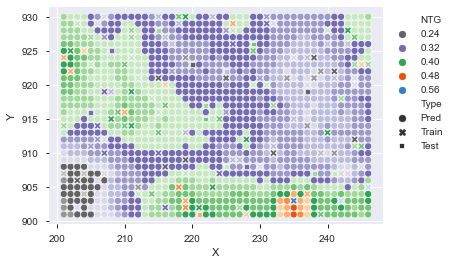

In [42]:
rnr_model = RadiusNeighborsRegressor()

params = {
    "radius": [9,10,11,12],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": [3,5,10,30,50],
    "p": [1, 2],
    "metric": ["minkowski"]    
}

search_rnr = GridSearchCV(rnr_model, 
                    param_grid=params,
                    cv=3,
                    scoring="neg_root_mean_squared_error",
                    verbose=1,
                    n_jobs=-1)
search_rnr.fit(X_train, y_train)
print(search_rnr.best_params_)

metrics_eval(y_test, search_rnr.best_estimator_.predict(X_test));
save_prediction(model=search_rnr.best_estimator_);

In [21]:
from sklearn.ensemble import VotingRegressor, StackingRegressor, BaggingRegressor,\
                            AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor,\
                            RandomForestRegressor

## HistGradientBoostingRegressor id=48962498

Mean Absolute Error: 0.045
Mean Squared Error: 0.003
Root Mean Squared Error: 0.056
Mean absolute percentage error: 13.366
Scaled Mean absolute percentage error: 14.527


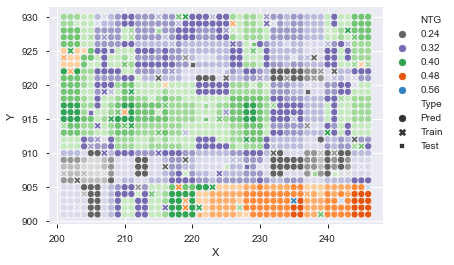

In [22]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

hist_grad_boost_model = HistGradientBoostingRegressor(learning_rate=0.1,
                                                      max_iter=500,
                                                      max_depth=4,
                                                      min_samples_leaf=8,
                                                      early_stopping=True,
                                                      scoring="neg_root_mean_squared_error",
                                                      l2_regularization=True,
                                                      random_state=13)
hist_grad_boost_model.fit(X_train, y_train)

metrics_eval(y_test, hist_grad_boost_model.predict(X_test));
save_prediction(model=hist_grad_boost_model);

## GradientBoostingRegressor

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 1060 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1690 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4336 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 5422 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 5832 out of 5832 | elapsed:  6.6min finished


{'criterion': 'mae', 'learning_rate': 0.1, 'loss': 'huber', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
Mean Absolute Error: 0.04
Mean Squared Error: 0.003
Root Mean Squared Error: 0.053
Mean absolute percentage error: 11.998
Scaled Mean absolute percentage error: 12.986


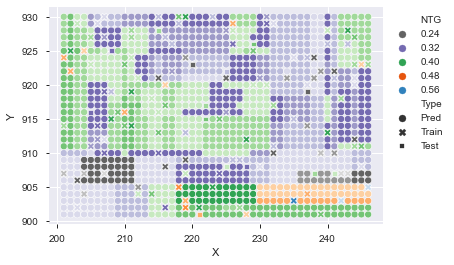

In [23]:
grad_boost_model = GradientBoostingRegressor(random_state=42,
                                             verbose=0)

params = {
    "loss" : ["ls", "lad", "huber", "quantile"],
    "learning_rate" : [0.1, 1],
    "n_estimators" : [10, 40, 100],
    "criterion" : ["mse", "mae", "friedman_mse"],
    "max_depth" : [None, 4, 10],
    "min_samples_split" : [2, 4, 10],
    "min_samples_leaf" : [1, 2, 4],
}

search_grad_boost_model = GridSearchCV(grad_boost_model, 
                                    param_grid=params,
                                    cv=3,
                                    scoring="neg_root_mean_squared_error",
                                    verbose=1,
                                    n_jobs=-1)

search_grad_boost_model.fit(X_train, y_train)
grad_boost_model = search_grad_boost_model.best_estimator_

print(search_grad_boost_model.best_params_)

metrics_eval(y_test, grad_boost_model.predict(X_test));
save_prediction(model=grad_boost_model);

## RandomForestRegressor id=48962560

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.1min finished


{'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Absolute Error: 0.047
Mean Squared Error: 0.004
Root Mean Squared Error: 0.063
Mean absolute percentage error: 14.095
Scaled Mean absolute percentage error: 15.735


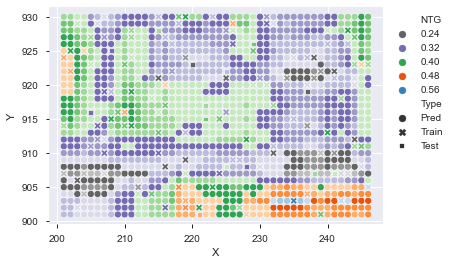

In [24]:
random_forest_model = RandomForestRegressor(n_jobs=-1,
                                            random_state=42,
                                            verbose=0)

params = {
    "n_estimators" : [10, 40, 100], # default=100
    "criterion" : ["mse", "mae"], # default=”mse”
    "max_depth" : [None, 4, 6, 10],
    "min_samples_split" : [2, 4, 6, 10],
    "min_samples_leaf" : [1, 2, 4],
    "max_features" : ["auto"],
}

search_random_forest_model = GridSearchCV(random_forest_model, 
                                    param_grid=params,
                                    cv=3,
                                    scoring="neg_root_mean_squared_error",
                                    verbose=1,
                                    n_jobs=-1)

search_random_forest_model.fit(X_train, y_train)
random_forest_model = search_random_forest_model.best_estimator_

print(search_random_forest_model.best_params_)

metrics_eval(y_test, random_forest_model.predict(X_test));
save_prediction(model=random_forest_model);

## ExtraTreesRegressor id = 49056437

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.1min finished


{'criterion': 'mse', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 40}
Mean Absolute Error: 0.047
Mean Squared Error: 0.003
Root Mean Squared Error: 0.055
Mean absolute percentage error: 14.289
Scaled Mean absolute percentage error: 15.156


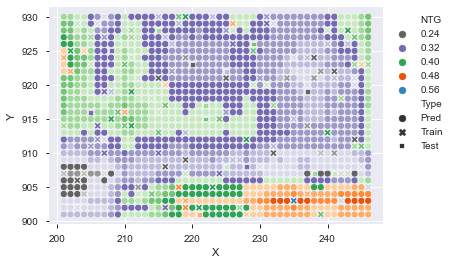

In [25]:
extra_trees_model = ExtraTreesRegressor(n_jobs=-1, random_state=42, verbose=0)

params = {
    "n_estimators" : [10, 40, 100], # default=100
    "criterion" : ["mse", "mae"], # default=”mse”
    "max_depth" : [None, 4, 6, 10],
    "min_samples_split" : [2, 4, 6, 10],
    "min_samples_leaf" : [1, 2, 4],
    "max_features" : ["auto"],
}

search_extra_trees_model = GridSearchCV(extra_trees_model, 
                                    param_grid=params,
                                    cv=3,
                                    scoring="neg_root_mean_squared_error",
                                    verbose=1,
                                    n_jobs=-1)

search_extra_trees_model.fit(X_train, y_train)
extra_trees_model = search_extra_trees_model.best_estimator_

print(search_extra_trees_model.best_params_)

metrics_eval(y_test, extra_trees_model.predict(X_test));
save_prediction(model=extra_trees_model);

## VotingRegressor id = 48960849

Mean Absolute Error: 0.04
Mean Squared Error: 0.002
Root Mean Squared Error: 0.048
Mean absolute percentage error: 11.862
Scaled Mean absolute percentage error: 12.725


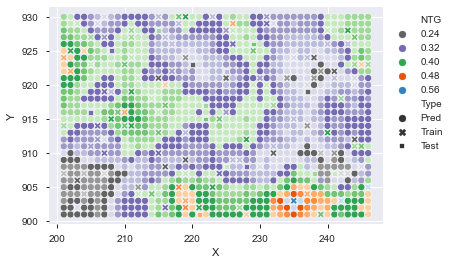

In [26]:
knr = KNeighborsRegressor(**search_knr.best_params_)

rnr = RadiusNeighborsRegressor(**search_rnr.best_params_)

voting_model = VotingRegressor([("KNeighborsRegressor",knr),
                                ("RadiusNeighborsRegressor",rnr)],
                               weights=(0.7, 0.3),
                               n_jobs=-1)
voting_model.fit(X_train, y_train)

metrics_eval(y_test, voting_model.predict(X_test));
save_prediction(model=voting_model);

## StackingRegressor id = 48961009

Mean Absolute Error: 0.038
Mean Squared Error: 0.002
Root Mean Squared Error: 0.043
Mean absolute percentage error: 11.576
Scaled Mean absolute percentage error: 12.008


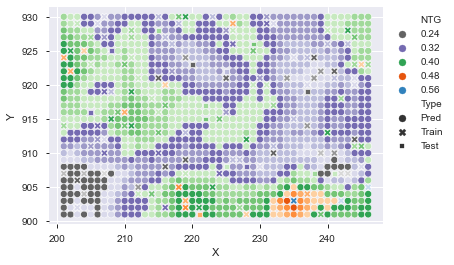

In [27]:
stacking_model = StackingRegressor([("KNeighborsRegressor",rnr),
                                    ("RadiusNeighborsRegressor",knr)],
                                   cv=3,
                                   n_jobs=-1)
stacking_model.fit(X_train, y_train)

metrics_eval(y_test, stacking_model.predict(X_test));
save_prediction(model=stacking_model);

## BaggingRegressor id = 48961113

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.9s finished


{'base_estimator': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, n_neighbors=4, p=1,
                    weights='distance'), 'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 5, 'oob_score': False, 'warm_start': False}
Mean Absolute Error: 0.043
Mean Squared Error: 0.003
Root Mean Squared Error: 0.055
Mean absolute percentage error: 12.663
Scaled Mean absolute percentage error: 13.972


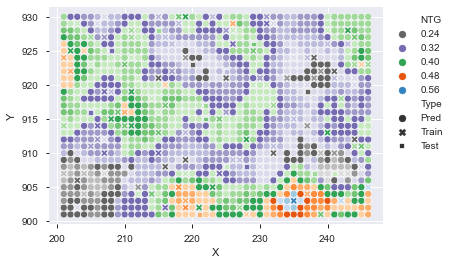

In [28]:
bagging_model = BaggingRegressor(n_jobs=-1, random_state=42, verbose=0)

params = {
    "base_estimator": [knr],
    "n_estimators" : [5,10,50,100],
    "max_samples" : [1.0],
    "max_features" : [1.0],
    "bootstrap" : [True, False],
    "bootstrap_features" : [False],
    "oob_score" : [False],
    "warm_start" : [False],
}

search_bagging_model = GridSearchCV(bagging_model, 
                                    param_grid=params,
                                    cv=3,
                                    scoring="neg_root_mean_squared_error",
                                    verbose=1,
                                    n_jobs=-1)

search_bagging_model.fit(X_train, y_train)
bagging_model = search_bagging_model.best_estimator_
print(search_bagging_model.best_params_)


metrics_eval(y_test, bagging_model.predict(X_test));
save_prediction(model=bagging_model);

## AdaBoostRegressor id=48961263

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   12.6s finished


{'learning_rate': 1, 'loss': 'exponential', 'n_estimators': 70}
Mean Absolute Error: 0.042
Mean Squared Error: 0.003
Root Mean Squared Error: 0.056
Mean absolute percentage error: 12.493
Scaled Mean absolute percentage error: 13.884


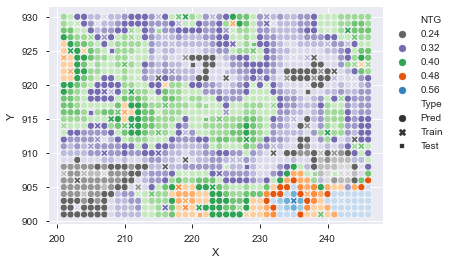

In [29]:
adaboost_model = AdaBoostRegressor(base_estimator=knr,
                                   random_state=42)

params = {
    "n_estimators" : [10, 40, 70, 100],
    "learning_rate" : [1, 0.1, 0.01, 1.5],
    "loss" : ["linear","square","exponential"],
}

search_adaboost_model = GridSearchCV(adaboost_model, 
                                    param_grid=params,
                                    cv=3,
                                    scoring="neg_root_mean_squared_error",
                                    verbose=1,
                                    n_jobs=-1)

search_adaboost_model.fit(X_train, y_train)
adaboost_model = search_adaboost_model.best_estimator_
print(search_adaboost_model.best_params_)

metrics_eval(y_test, adaboost_model.predict(X_test));
save_prediction(model=adaboost_model);

## Scipy interpolation

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

In [30]:
# from scipy.interpolate import griddata

# points = train_df[features_names].values
# values = train_df.NTG.values
# grid_x, grid_y = np.mgrid[201:247, 901:931]

# for method in ["nearest", "linear", "cubic"]:
#     grid_res = griddata(points, values, (grid_x, grid_y), method=method)
#     plot_interpolation(grid_res, "grid_" + method)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html#scipy.interpolate.CloughTocher2DInterpolator

In [32]:
from scipy.interpolate import CloughTocher2DInterpolator, NearestNDInterpolator, LinearNDInterpolator

class Interpolator():
    def __init__(self, model):
        self.model = model
        self.trained_model = None
    
    def train(self, train_data):
        x = train_data.X.values
        y = train_data.Y.values
        z = train_data[target_name].values
        
        # train main model
        self.trained_model = self.model(list(zip(x, y)), z)
        
    def predict(self, input_data, extrapolate=True):
        assert self.trained_model is not None
        x = input_data.X.values
        y = input_data.Y.values
        X = np.arange(min(x), max(x)+1)
        Y = np.arange(min(y), max(y)+1)
        X, Y = np.meshgrid(X, Y)
        
        hulf_res = self.trained_model(X, Y).transpose()
        res_to_melt = pd.DataFrame(hulf_res,
                                   index=range(min(x), max(x)+1),
                                   columns=range(min(y),max(y)+1))
        interpolation_df = pd.melt(res_to_melt, ignore_index=False).reset_index().dropna()
        interpolation_df.columns = ["X","Y", "NTG"]
        
        # repredict nan values by NearestNDInterpolator
        if extrapolate:
            x_ = interpolation_df.X.values
            y_ = interpolation_df.Y.values
            z_ = interpolation_df[target_name].values

            nn_interpolate = NearestNDInterpolator(list(zip(x_, y_)), z_)
            res = nn_interpolate(X, Y).transpose()
            res_to_melt = pd.DataFrame(res,
                                       index=range(min(x), max(x)+1),
                                       columns=range(min(y),max(y)+1))
            interpolation_df = pd.melt(res_to_melt, ignore_index=False).reset_index().dropna()
            interpolation_df.columns = ["X","Y", "NTG"]
        
        # Merge to pred df
        result = input_data.merge(interpolation_df, how="left")
        return result[target_name]

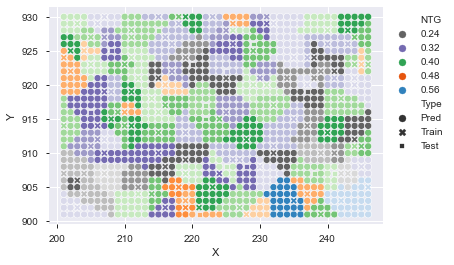

In [33]:
NearestND_model = Interpolator(model=NearestNDInterpolator)
NearestND_model.train(train_data=train_df)

save_prediction(model=NearestND_model);

## id = 48961408

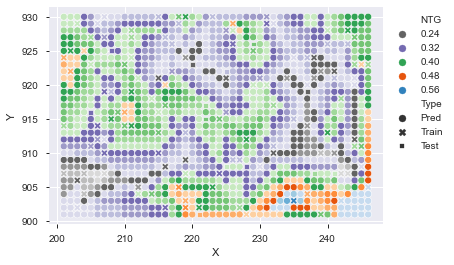

In [34]:
LinearND_model = Interpolator(model=LinearNDInterpolator)
LinearND_model.train(train_data=train_df)

save_prediction(model=LinearND_model);

## id = 48961461

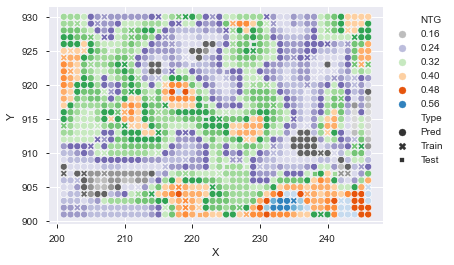

In [35]:
CloughTocher2D_model = Interpolator(model=CloughTocher2DInterpolator)
CloughTocher2D_model.train(train_data=train_df)

save_prediction(model=CloughTocher2D_model);

## Aggregate predictions

In [36]:
class Aggregator():
    def __init__(self, mode, models):
        self.mode = mode
        self.models = models
        self.names = []
    
    def predict(self, input_data):
        agg_df = input_data.copy()
        
        for model in self.models:
            model_name = str(type(model)).strip("''<>").split('.')[-1]
            self.names.append(model_name)
            agg_df[model_name] = np.array(model.predict(input_data)).reshape(-1)
        
        if self.mode == "mean":
            agg_df[target_name] = agg_df[self.names].mean(axis=1)
        elif self.mode == "min":
            agg_df[target_name] = agg_df[self.names].min(axis=1)
        elif self.mode == "max":
            agg_df[target_name] = agg_df[self.names].max(axis=1)
        elif self.mode == "median":
            agg_df[target_name] = agg_df[self.names].median(axis=1)
        
        return agg_df[target_name]

In [37]:
models_to_agg = [search_knr.best_estimator_, search_rnr.best_estimator_,
#                  hist_grad_boost_model,grad_boost_model, extra_trees_model,
                 voting_model, stacking_model, bagging_model, adaboost_model,
                 LinearND_model, CloughTocher2D_model, random_forest_model]

## id = 48961643

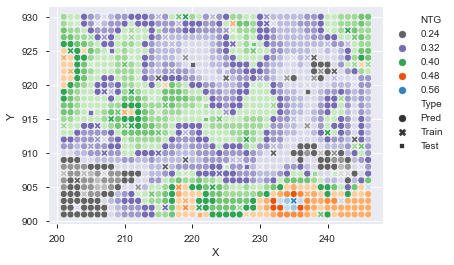

In [38]:
mean_aggregator = Aggregator("mean", models_to_agg)
save_prediction(model=mean_aggregator);

## id = 48961775

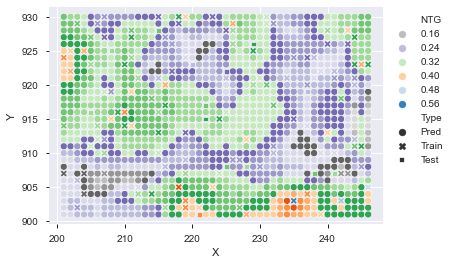

In [39]:
min_aggregator = Aggregator("min", models_to_agg)
save_prediction(model=min_aggregator);

## id = 48961858

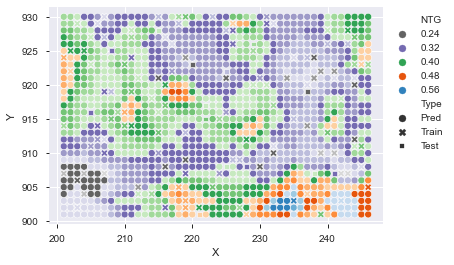

In [40]:
max_aggregator = Aggregator("max", models_to_agg)
save_prediction(model=max_aggregator);

## id = 48961989

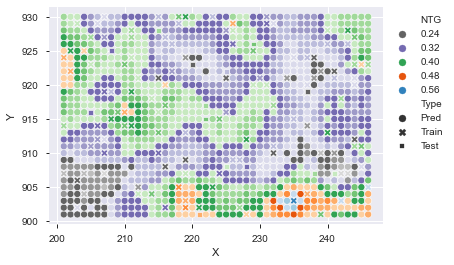

In [41]:
median_aggregator = Aggregator("median", models_to_agg)
save_prediction(model=median_aggregator);

## Train best models on all train data

## id = 48963521

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   45.9s finished


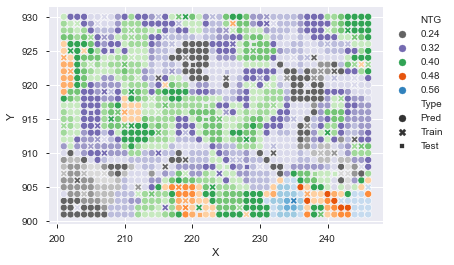

In [44]:
all_knr_model = KNeighborsRegressor(n_jobs=-1)

params = {
    "n_neighbors": [2,4,5,6,8],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": [3,5,10,30,50],
    "p": [1, 2],
    "metric": ["minkowski"]    
}

all_search_knr = GridSearchCV(all_knr_model, 
                    param_grid=params,
                    cv=3,
                    scoring="neg_root_mean_squared_error",
                    verbose=1,
                    n_jobs=-1)
all_search_knr.fit(train_df[features_names], train_df[target_name])

save_prediction(model=all_search_knr.best_estimator_);

## id = 48963617

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.9s finished


{'base_estimator': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, n_neighbors=4, p=1,
                    weights='distance'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 5, 'oob_score': False, 'warm_start': False}


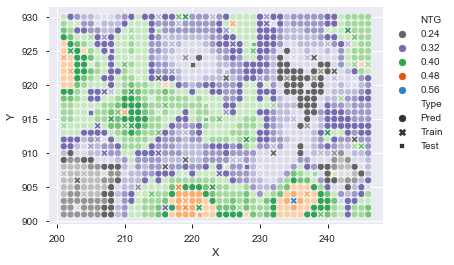

In [45]:
all_bagging_model = BaggingRegressor(n_jobs=-1, random_state=42, verbose=0)

params = {
    "base_estimator": [knr],
    "n_estimators" : [5,10,50,100],
    "max_samples" : [1.0],
    "max_features" : [1.0],
    "bootstrap" : [True, False],
    "bootstrap_features" : [False],
    "oob_score" : [False],
    "warm_start" : [False],
}

all_search_bagging_model = GridSearchCV(all_bagging_model, 
                                    param_grid=params,
                                    cv=3,
                                    scoring="neg_root_mean_squared_error",
                                    verbose=1,
                                    n_jobs=-1)

all_search_bagging_model.fit(train_df[features_names], train_df[target_name])
all_bagging_model = all_search_bagging_model.best_estimator_
print(all_search_bagging_model.best_params_)

save_prediction(model=all_bagging_model);

## id = 48963799

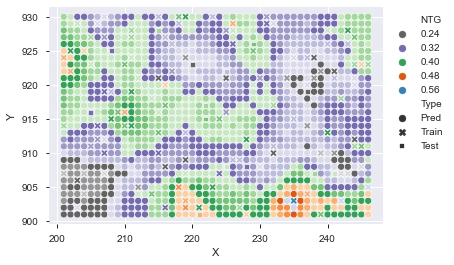

In [46]:
knr = KNeighborsRegressor(**search_knr.best_params_)
rnr = RadiusNeighborsRegressor(**search_rnr.best_params_)

all_voting_model = VotingRegressor([("KNeighborsRegressor",knr),
                                ("RadiusNeighborsRegressor",rnr)],
                               weights=(0.7, 0.3),
                               n_jobs=-1)
all_voting_model.fit(train_df[features_names], train_df[target_name])

save_prediction(model=all_voting_model);

In [47]:
all_models_to_agg = [all_search_knr.best_estimator_, all_bagging_model, all_voting_model]

## id = 48963903

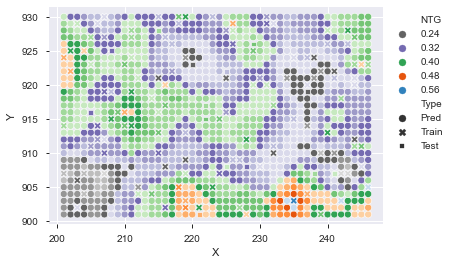

In [48]:
all_mean_aggregator = Aggregator("mean", all_models_to_agg)
save_prediction(model=all_mean_aggregator);

# id = 48963965

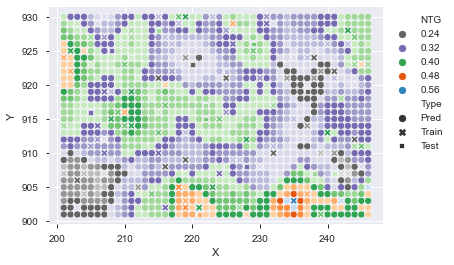

In [49]:
all_median_aggregator = Aggregator("median", all_models_to_agg)
save_prediction(model=all_median_aggregator);